<a href="https://colab.research.google.com/github/mfarias76/MVP_PUCRJ_Sprint2_Engenharia-de-Dados/blob/main/Sprint2_PUC_Rio_Workspace_Mario_Farias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MVP: Engenharia de Dados (40530010057_20250_02)**
**Autor:** Mario Henrique Botelho Farias  

**Data:** 01/12/2025

**Matrícula:** 4052025001116

**Dataset:** [Jurassic Park Dataset] https://www.kaggle.com/datasets/kjanjua/jurassic-park-the-exhaustive-dinosaur-dataset/data


#**1. Objetivo**

Escolhi o *dataset, Jurassic Park - The Exhaustive Dinosaur Dataset* para o meu projeto de pesquisa acadêmica por um motivo fascinante: a imensa diversidade de espécies de dinossauros que existiram em nosso planeta. Essa riqueza não é apenas um tesouro biológico, mas uma oportunidade ímpar para análise de dados.

Cada espécie representa um conjunto único de características, desde seu **tamanho e dieta** até a sua **distribuição geográfica** e **período de existência**. Essa variedade nos permite criar projeções e modelos analíticos robustos, explorando as diferenças e correlações entre os grupos. É como ter um laboratório natural de Big Data, onde cada fóssil conta uma história que pode ser quantificada.

Para gerenciar e consultar essa vasta e complexa teia de informações de forma eficiente, a implementação de um *Data Warehouse* é fundamental. Essa estrutura nos permitirá extrair respostas precisas e rápidas para perguntas cruciais, transformando dados brutos em conhecimento:

  1. Quais dinossauros aparecem em mais de um continente? (Foco na distribuição global e migração)

  2. Qual paleontólogo descobriu mais de uma espécie? (Foco na produtividade científica e atribuição)

  3. Quais países têm maior concentração de dinossauros? (Foco na abundância de registros fósseis por localidade)

  4. Quais são os dinossauros com período de existência mais antigos? (Foco na cronologia e origem das espécies)

  5. Qual a quantidade de dinossauros por espécie? (Foco na contagem e prevalência de cada tipo)

  6. Qual a quantidade de dinossauros, observando a dieta? (Foco na classificação e proporção entre herbívoros, carnívoros, etc.)

  7. Qual seria a ordenação dos maiores dinossauros para os menores em comprimento? (Foco na dimensão física e classificação de porte)

Os conceitos aprendidos nessa fase, garantem que as análises sobre a diversidade, distribuição e características dos dinossauros sejam realizadas de maneira organizada e escalável, fundamentando as conclusões do nosso estudo.

#**2. Coleta dos dados brutos no CSV**

In [3]:
#Autenticacao Colab
from google.colab import auth
auth.authenticate_user()

print("Autenticação concluída.")

Autenticação concluída.


In [4]:
#Autenticacao BigQuery
from google.cloud import bigquery

PROJECT_ID = "sapient-hub-480016-f7"
client = bigquery.Client(project=PROJECT_ID)

print("Cliente BigQuery criado para o projeto:", PROJECT_ID)

Cliente BigQuery criado para o projeto: sapient-hub-480016-f7


In [5]:
#Consulta teste BigQuery
import pandas as pd

QUERY = """
SELECT *
FROM `sapient-hub-480016-f7.dino_bi.vw_dino_analitico`
LIMIT 1000
"""

df = client.query(QUERY).to_dataframe()
df.head()

,id_dinossauro,id_dieta,id_periodo,id_localizacao,id_classificacao,id_descoberta,nome_dinossauro,especie,dieta_original,dieta_classificada,...,periodo_raw,periodo_macro,localizacao_original,continente_inferido,tipo_dinossauro,taxonomia,nomeadores,referencia,length_m,qtde
0,c26a68c2-c547-4092-b14a-45254c8f636c,1dd44590-3c14-44ba-a7aa-bff3193e065b,9d1f27d2-7f98-43d8-85a5-eca953dd2f15,dfab3161-9c62-4de2-b329-16cdf7d9fae2,0bc85f58-9db2-462b-be03-df0b16c7c556,7c505d22-d47d-463e-a462-3442968dfaec,opisthocoelicaudia,skarzynskii,herbivorous,Herbívoro,...,Late Cretaceous 72-68 million years ago,Mesozoico - Cretáceo,Mongolia,Ásia,sauropod,Dinosauria Saurischia Sauropodomorpha Sauropod...,Borsuk-Bialynicka (1977),https://www.nhm.ac.uk/discover/dino-directory/...,12.0,1
1,073ce1fb-e0e3-4fd6-ae3f-4f95c678127a,1dd44590-3c14-44ba-a7aa-bff3193e065b,2e3d89f1-2d04-49b3-8536-99a86f23107f,e2bb5cd0-9494-4f3a-951e-341db40a8e22,0bc85f58-9db2-462b-be03-df0b16c7c556,7fd0d05a-d6fb-4768-9b18-1dbd1064651f,neuquenosaurus,australis,herbivorous,Herbívoro,...,Late Cretaceous 71-65 million years ago,Mesozoico - Cretáceo,Argentina,América do Sul,sauropod,Dinosauria Saurischia Sauropodomorpha Sauropod...,Lydekker (1893),https://www.nhm.ac.uk/discover/dino-directory/...,10.0,1
2,01fc826c-3955-44e8-af17-0f10c0984580,1dd44590-3c14-44ba-a7aa-bff3193e065b,4c047c38-9a16-40d5-b0b0-fafa3b6e2ac8,e2bb5cd0-9494-4f3a-951e-341db40a8e22,0bc85f58-9db2-462b-be03-df0b16c7c556,ef23bb01-17ac-4a18-9066-474da22a3f70,saltasaurus,loricatus,herbivorous,Herbívoro,...,Late Cretaceous 70-65 million years ago,Mesozoico - Cretáceo,Argentina,América do Sul,sauropod,Dinosauria Saurischia Sauropodomorpha Sauropod...,Bonaparte and Powell (1980),https://www.nhm.ac.uk/discover/dino-directory/...,12.0,1
3,5e08ad20-82fb-42f5-a5f2-dbce635597a2,1dd44590-3c14-44ba-a7aa-bff3193e065b,e064e901-f6e4-4743-8c31-d5f9b0769e08,f687a4cb-d6cc-47ac-b355-1610f652db64,0ca15c40-d81d-480b-a59d-d9fdd4630aca,a3f04384-3f01-4192-b11b-a786be6ebb92,albertaceratops,nesmoi,herbivorous,Herbívoro,...,Late Cretaceous 80-75 million years ago,Mesozoico - Cretáceo,USA,América do Norte,ceratopsian,Dinosauria Ornithischia,Ryan 2007,https://www.nhm.ac.uk/discover/dino-directory/...,7.0,1
4,f69753fc-1798-4326-b5e8-dbf0a693e8fe,1dd44590-3c14-44ba-a7aa-bff3193e065b,4c047c38-9a16-40d5-b0b0-fafa3b6e2ac8,f687a4cb-d6cc-47ac-b355-1610f652db64,0ced5a5a-a079-4515-abe8-cc2a57c986ab,5c5c7181-e176-42db-a999-867117ce4dd4,alamosaurus,sanjuanensis,herbivorous,Herbívoro,...,Late Cretaceous 70-65 million years ago,Mesozoico - Cretáceo,USA,América do Norte,sauropod,Dinosauria Saurischia Sauropodomorpha Sauropod...,Gilmore (1922),https://www.nhm.ac.uk/discover/dino-directory/...,21.0,1


# **3. Modelagem dos dados**

In [8]:
# Função para executar as query SQL
def run_query(sql):
    from google.cloud import bigquery
    client = bigquery.Client(project="sapient-hub-480016-f7")
    return client.query(sql).to_dataframe()

In [24]:
# Teste de consulta ao dados
sql = """
SELECT dieta_classificada, COUNT(*) AS total
FROM `sapient-hub-480016-f7.dino_bi.vw_dino_analitico`
GROUP BY dieta_classificada
ORDER BY total DESC
"""
df_dieta = run_query(sql)
df_dieta

,dieta_classificada,total
0,Herbívoro,183
1,Carnívoro,92
2,Onívoro,27
3,Desconhecido,2


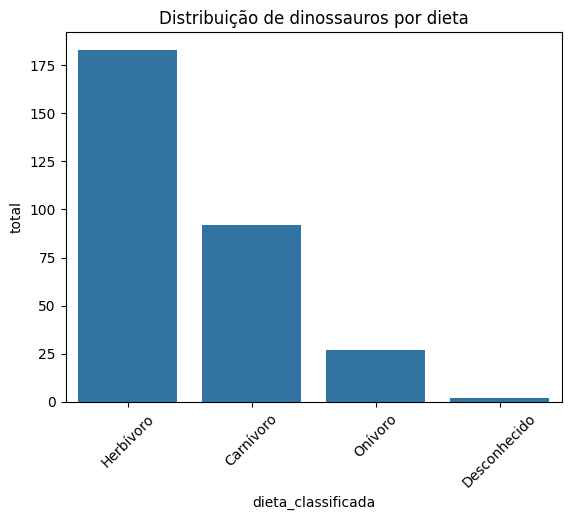

In [19]:
# Teste de representação em gráfico

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=q6, x="dieta_classificada", y="total")
plt.title("Distribuição de dinossauros por dieta")
plt.xticks(rotation=45)
plt.show()

In [45]:
# Preparando view Analítica
# Obtendo o schema da vw_dino_analitico

from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "sapient-hub-480016-f7"
client = bigquery.Client(project=PROJECT_ID)

In [46]:
#Captura dos metadados

table = client.get_table("sapient-hub-480016-f7.dino_bi.vw_dino_analitico")

schema_rows = []
for field in table.schema:
    schema_rows.append({
        "nome_campo": field.name,
        "tipo_bq": field.field_type,
        "modo": field.mode,
        "descricao": field.description or ""
    })

schema_df = pd.DataFrame(schema_rows)
schema_df

,nome_campo,tipo_bq,modo,descricao
0,qtde,INTEGER,NULLABLE,
1,length_m,FLOAT,NULLABLE,
2,name,STRING,NULLABLE,
3,species,STRING,NULLABLE,
4,diet,STRING,NULLABLE,
5,period_name,STRING,NULLABLE,
6,period_raw,STRING,NULLABLE,
7,lived_in,STRING,NULLABLE,
8,type,STRING,NULLABLE,
9,taxonomy,STRING,NULLABLE,


In [54]:
# Mapeamento manual de dimensões e métricas
dimensoes = [
    "id_dinossauro",
    "id_dieta",
    "id_periodo",
    "id_localizacao",
    "id_classificacao",
    "id_descoberta",
    "nome_dinossauro",
    "especie",
    "taxonomia",
    "dieta_original",
    "dieta_classificada",
    "periodo_nome",
    "periodo_raw",
    "periodo_macro",
    "localizacao_original",
    "continente_inferido",
    "tipo_dinossauro",
    "nomeadores",
    "referencia"
]

metricas = [
    "length_m",
    "qtde"
]

def classificar_campo(nome):
    if nome in dimensoes:
        return "Dimensão"
    if nome in metricas:
        return "Métrica"
    return "Outros"

schema_df["semantica_bi"] = schema_df["nome_campo"].apply(classificar_campo)
schema_df.sort_values(["semantica_bi", "nome_campo"])

,nome_campo,tipo_bq,modo,descricao,semantica_bi
1,length_m,FLOAT,NULLABLE,,Métrica
0,qtde,INTEGER,NULLABLE,,Métrica
4,diet,STRING,NULLABLE,,Outros
11,link,STRING,NULLABLE,,Outros
7,lived_in,STRING,NULLABLE,,Outros
2,name,STRING,NULLABLE,,Outros
10,named_by,STRING,NULLABLE,,Outros
5,period_name,STRING,NULLABLE,,Outros
6,period_raw,STRING,NULLABLE,,Outros
3,species,STRING,NULLABLE,,Outros


In [48]:
# Só dimensões
schema_df[schema_df["semantica_bi"] == "Dimensão"]


,nome_campo,tipo_bq,modo,descricao,semantica_bi


In [49]:
# Só métricas
schema_df[schema_df["semantica_bi"] == "Métrica"]

,nome_campo,tipo_bq,modo,descricao,semantica_bi
0,qtde,INTEGER,NULLABLE,,Métrica
1,length_m,FLOAT,NULLABLE,,Métrica


In [50]:
%%bigquery vista_preview --project sapient-hub-480016-f7

SELECT
  *
FROM `sapient-hub-480016-f7.dino_bi.vw_dino_analitico`
LIMIT 50

Query is running:   0%|          |

Downloading:   0%|          |

## **4. Carga dos dados tratados**

In [51]:
# registro de dinossauro em um contexto dimensional completo

vista_preview.head()

,qtde,length_m,name,species,diet,period_name,period_raw,lived_in,type,taxonomy,named_by,link
0,1,12.0,opisthocoelicaudia,skarzynskii,herbivorous,Late Cretaceous 72-68 million years ago,Late Cretaceous 72-68 million years ago,Mongolia,sauropod,Dinosauria Saurischia Sauropodomorpha Sauropod...,Borsuk-Bialynicka (1977),https://www.nhm.ac.uk/discover/dino-directory/...
1,1,10.0,neuquenosaurus,australis,herbivorous,Late Cretaceous 71-65 million years ago,Late Cretaceous 71-65 million years ago,Argentina,sauropod,Dinosauria Saurischia Sauropodomorpha Sauropod...,Lydekker (1893),https://www.nhm.ac.uk/discover/dino-directory/...
2,1,12.0,saltasaurus,loricatus,herbivorous,Late Cretaceous 70-65 million years ago,Late Cretaceous 70-65 million years ago,Argentina,sauropod,Dinosauria Saurischia Sauropodomorpha Sauropod...,Bonaparte and Powell (1980),https://www.nhm.ac.uk/discover/dino-directory/...
3,1,7.0,albertaceratops,nesmoi,herbivorous,Late Cretaceous 80-75 million years ago,Late Cretaceous 80-75 million years ago,USA,ceratopsian,Dinosauria Ornithischia,Ryan 2007,https://www.nhm.ac.uk/discover/dino-directory/...
4,1,21.0,alamosaurus,sanjuanensis,herbivorous,Late Cretaceous 70-65 million years ago,Late Cretaceous 70-65 million years ago,USA,sauropod,Dinosauria Saurischia Sauropodomorpha Sauropod...,Gilmore (1922),https://www.nhm.ac.uk/discover/dino-directory/...


## View analítica para BI: `vw_dino_analitico`

- **Projeto:** `sapient-hub-480016-f7`
- **Dataset:** `dino_bi`
- **View:** `vw_dino_analitico`
- **Grão da view:** 1 linha por dinossauro (combinado às dimensões de dieta, período, localização, classificação e descoberta).

### Categorias semânticas

- **Dimensões:** identificadores e atributos descritivos (nome_dinossauro, especie, continente_inferido, periodo_macro, dieta_classificada, etc.)
- **Métricas:** medidas numéricas (length_m, qtde).

A tabela `schema_df` abaixo apresenta o catálogo de campos da view, incluindo tipo e classificação semântica (Dimensão/Métrica).


In [56]:
schema_df.sort_values(["semantica_bi", "nome_campo"])

,nome_campo,tipo_bq,modo,descricao,semantica_bi
1,length_m,FLOAT,NULLABLE,,Métrica
0,qtde,INTEGER,NULLABLE,,Métrica
4,diet,STRING,NULLABLE,,Outros
11,link,STRING,NULLABLE,,Outros
7,lived_in,STRING,NULLABLE,,Outros
2,name,STRING,NULLABLE,,Outros
10,named_by,STRING,NULLABLE,,Outros
5,period_name,STRING,NULLABLE,,Outros
6,period_raw,STRING,NULLABLE,,Outros
3,species,STRING,NULLABLE,,Outros


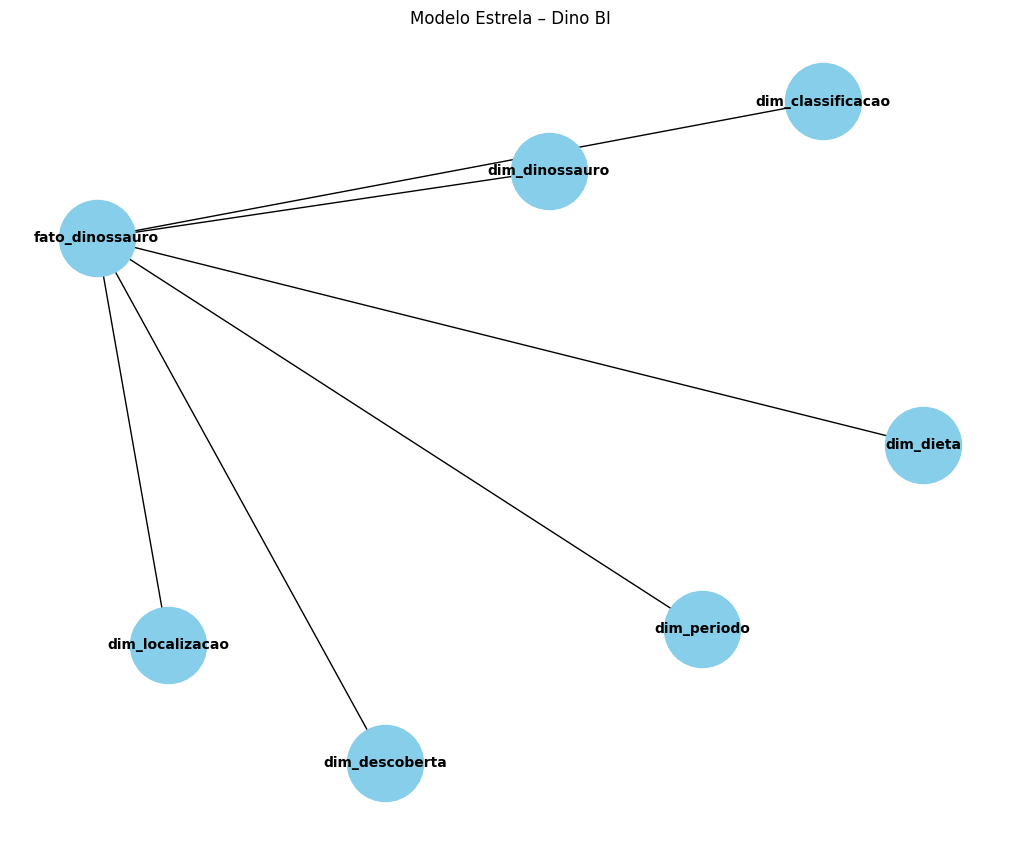

In [55]:
# Representação do modelo estrela

import matplotlib.pyplot as plt
import networkx as nx

# Create directed graph
G = nx.DiGraph()

# Fact table
G.add_node("fato_dinossauro")

# Dimension tables
dims = [
    "dim_dinossauro",
    "dim_dieta",
    "dim_periodo",
    "dim_localizacao",
    "dim_classificacao",
    "dim_descoberta"
]

# Add edges (dimension → fact)
for d in dims:
    G.add_node(d)
    G.add_edge(d, "fato_dinossauro")

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=7)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="skyblue",
    node_size=3000,
    font_size=10,
    font_weight="bold",
    arrows=False
)

plt.title("Modelo Estrela – Dino BI")
plt.show()

## **5. Análise as questões apresentadas**

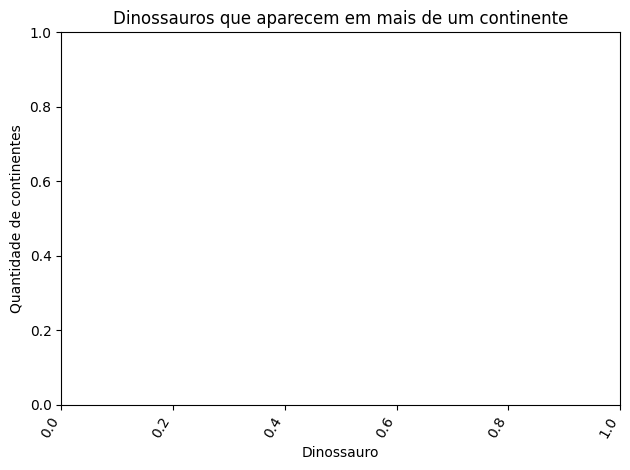

In [25]:
# Quais dinossauros aparecem em mais de um continente?

q1_plot = q1.sort_values("qtd_continentes", ascending=False).head(20)

plt.figure()
sns.barplot(data=q1_plot,
            x="nome_dinossauro",
            y="qtd_continentes")
plt.title("Dinossauros que aparecem em mais de um continente")
plt.xlabel("Dinossauro")
plt.ylabel("Quantidade de continentes")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

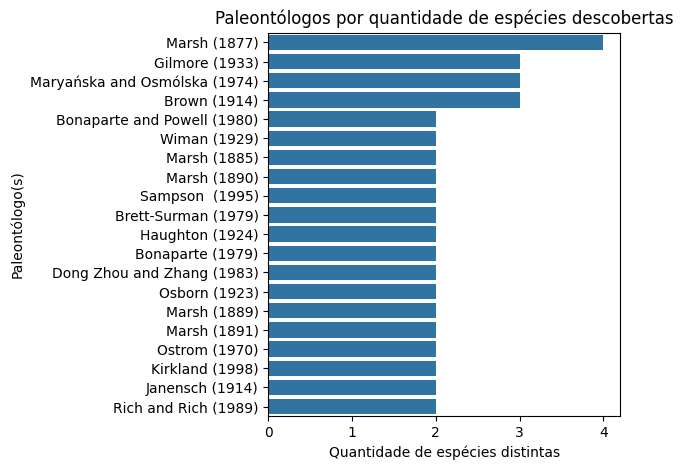

In [26]:
# Qual paleontogo descobriu mais de uma espécie?

q2_plot = q2.sort_values("qtd_especies", ascending=False).head(20)

plt.figure()
sns.barplot(data=q2_plot,
            x="qtd_especies",
            y="nomeadores")
plt.title("Paleontólogos por quantidade de espécies descobertas")
plt.xlabel("Quantidade de espécies distintas")
plt.ylabel("Paleontólogo(s)")
plt.tight_layout()
plt.show()

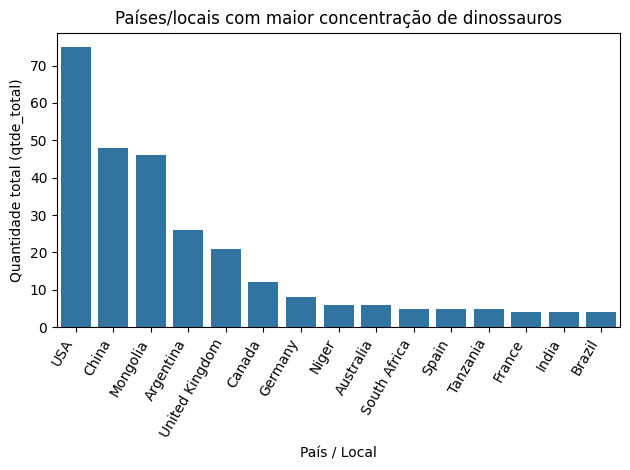

In [27]:
# Quais países têm maior concentração de dinossauros?

q3_plot = q3.sort_values("qtde_total", ascending=False).head(15)

plt.figure()
sns.barplot(data=q3_plot,
            x="pais",
            y="qtde_total")
plt.title("Países/locais com maior concentração de dinossauros")
plt.xlabel("País / Local")
plt.ylabel("Quantidade total (qtde_total)")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

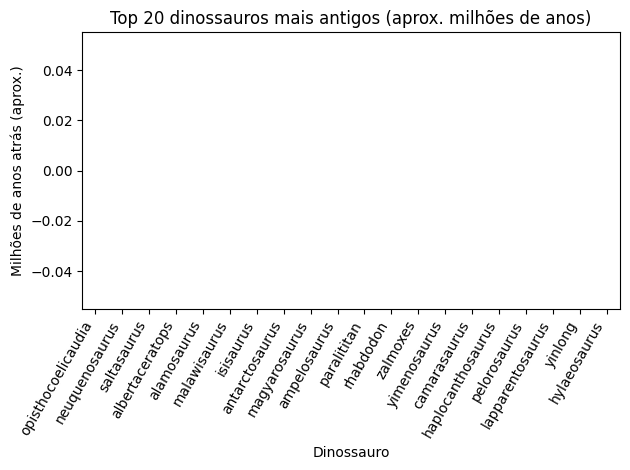

In [28]:
# Quais são os dinossauros com periodo de existência mais antigos?

q4["millions_years_ago"] = q4["millions_years_ago"].astype("float")

# Pegar top 20 mais antigos
q4_plot = q4.sort_values("millions_years_ago", ascending=False).head(20)

plt.figure()
sns.barplot(data=q4_plot,
            x="nome_dinossauro",
            y="millions_years_ago")
plt.title("Top 20 dinossauros mais antigos (aprox. milhões de anos)")
plt.xlabel("Dinossauro")
plt.ylabel("Milhões de anos atrás (aprox.)")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

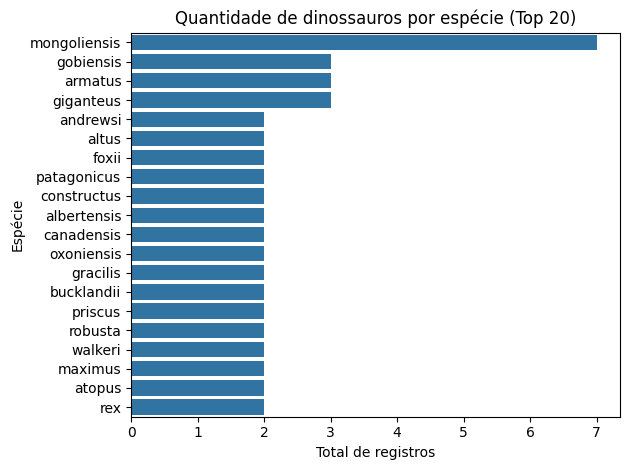

In [29]:
# Qual a quantidade de dinossauros por espécie?

q5_plot = q5.sort_values("total", ascending=False).head(20)

plt.figure()
sns.barplot(data=q5_plot,
            x="total",
            y="especie")
plt.title("Quantidade de dinossauros por espécie (Top 20)")
plt.xlabel("Total de registros")
plt.ylabel("Espécie")
plt.tight_layout()
plt.show()

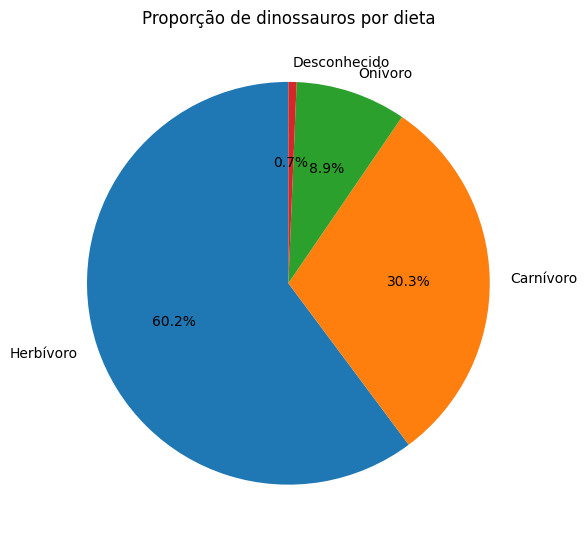

In [31]:
# Qual a quantidade dinossauros, observando a dieta?

plt.figure(figsize=(6,6))
plt.pie(q6["total"],
        labels=q6["dieta_classificada"],
        autopct="%1.1f%%",
        startangle=90)
plt.title("Proporção de dinossauros por dieta")
plt.tight_layout()
plt.show()

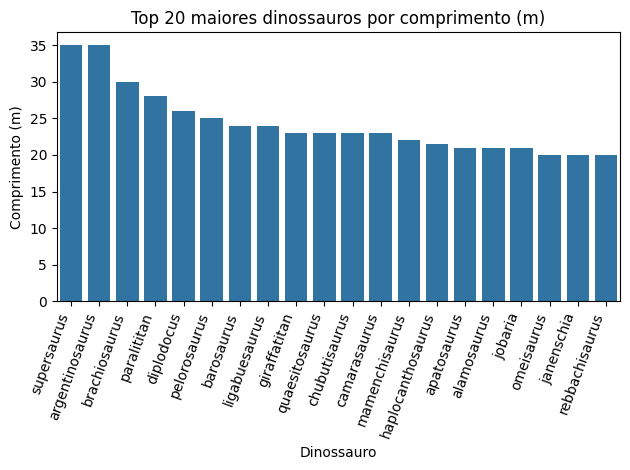

In [32]:
# Qual seria a ordenação dos maiores dinossauros, para o menores em comprimento?

q7["length_m"] = q7["length_m"].astype("float")

# Top 20 maiores
q7_plot = q7.sort_values("length_m", ascending=False).head(20)

plt.figure()
sns.barplot(data=q7_plot,
            x="nome_dinossauro",
            y="length_m")
plt.title("Top 20 maiores dinossauros por comprimento (m)")
plt.xlabel("Dinossauro")
plt.ylabel("Comprimento (m)")
plt.xticks(rotation=70, ha="right")
plt.tight_layout()
plt.show()

## **6. Autoavaliação**


**Desenvolvimento do MVP de Análise de Dados**

  O desenvolvimento deste MVP constituiu uma oportunidade relevante para aprofundar conhecimentos práticos em engenharia e análise de dados, permitindo exercitar desde a seleção da base informacional até a construção de um modelo dimensional, a elaboração de consultas analíticas e a visualização dos resultados. Ao longo desse processo, emergiram desafios conceituais, técnicos e operacionais que contribuíram significativamente para a consolidação do meu aprendizado.

  Inicialmente, a etapa de definição do tema do projeto revelou-se mais complexa do que o previsto. A exigência de empregar bases de dados abertas, aliada à necessidade de assegurar diversidade suficiente de atributos para viabilizar uma modelagem analítica estruturada, restringiu consideravelmente as opções disponíveis. Nos "Requisitos para o Desenvolvimento do MVP", havia um tópico sobre debate de ideias no Discord, a fim de montar colaborativamente um repositório de possibilidades, mas não identifiquei esse tópico, prolongando a fase exploratória e evidenciando a dificuldade em identificar um dataset público que fosse, ao mesmo tempo, consistente, completo e adequado para fins acadêmicos.


**Escolha do Dataset**

  Após refletir sobre alternativas, optei por escolher um tema menos tradicional, mas com boa estrutura de dados: um dataset sobre dinossauros, contendo informações categóricas e textuais que permitiriam análises descritivas, modelagem dimensional e construção de uma visão analítica integrada. Paradoxalmente, a simplicidade da base acabou se tornando também um desafio, pois muitos atributos precisaram ser interpretados, padronizados ou reclassificados para viabilizar um esquema estrela consistente.


**Construção do MVP**

  Outro ponto de destaque foi a tentativa inicial de estruturar o pipeline de dados utilizando o Databricks. Apesar de sua relevância no mercado e da expectativa positiva em relação ao ambiente, a versão gratuita mostrou-se inadequada para o escopo do MVP, devido a inúmeras limitações práticas. Problemas como instâncias encerrando automaticamente, impossibilidade de executar determinadas operações essenciais, e restrições de permissões comprometeram a continuidade dos experimentos e demandaram tempo significativo de troubleshooting, sem retorno satisfatório. A versão *Databricks Community Edition* indicada no "Requisitos para o Desenvolvimento do MVP" não estava operacional durante todas as etpas de montagem do MVP.

**Solução**

  Em razão desses entraves, optei pela migração para o Google BigQuery, decisão que se revelou acertada do ponto de vista acadêmico e operacional. O BigQuery possibilitou uma experiência mais fluida e estável para armazenamento, transformação e consulta dos dados, além de oferecer integração direta com ferramentas como Google Colab e Looker Studio. Essa mudança permitiu avançar de forma estruturada para a implementação do modelo estrela, composto por tabelas de dimensão e de fato, e para a construção de uma view analítica integrada (vw_dino_analitico), para as análises subsequentes.

  Do ponto de vista técnico, a elaboração das consultas SQL apresentou desafios importantes, sobretudo na manipulação de dados textuais, na extração de entidades implícitas, na criação de classificações auxiliares e na adequação de joins ao modelo dimensional efetivamente implementado. A integração com o Google Colab também exigiu atenção, especialmente no que se refere à autenticação do BigQuery e ao tratamento de exceções geradas pelo cliente Python.

  Apesar dessas dificuldades, o conjunto de atividades realizadas proporcionou uma visão abrangente das etapas fundamentais de um pipeline analítico. A necessidade de reavaliar ferramentas e adaptar estratégias — como no caso da substituição do Databricks pelo BigQuery — reforçou a importância da análise crítica e da tomada de decisão fundamentada em viabilidade técnica e eficiência operacional.

  Por fim, o desenvolvimento deste MVP contribuiu de forma significativa para o aprimoramento das competências relacionadas à engenharia e análise de dados, oferecendo uma experiência aplicada que transcende a teoria e evidencia as complexidades presentes no trabalho com dados no ambiente profissional contemporâneo.